# UFC Predictor 

Notebook for:
- Data exploration and cleaning
- Preprocessing / Feature Engineering
- Other data analysis

In [15]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import OneHotEncoder

from datetime import datetime, timedelta
from collections import defaultdict

In [16]:
df = pd.read_csv('../datasets/ufc-master.csv')

# Dataset shape and basic info
print("UFC dataframe shape:", df.shape)   
print(df.info())

# The 'Date' column can be converted to "datetime" objects for ease of use
df['Date'] = pd.to_datetime(df['Date'])


UFC dataframe shape: (6528, 118)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6528 entries, 0 to 6527
Columns: 118 entries, RedFighter to BKOOdds
dtypes: bool(1), float64(60), int64(43), object(14)
memory usage: 5.8+ MB
None


In [17]:
# Sample 5 random rows and display first 10 columsn
df.sample(5).iloc[:, :10] 

,RedFighter,BlueFighter,RedOdds,BlueOdds,RedExpectedValue,BlueExpectedValue,Date,Location,Country,Winner
2890,Robbie Lawler,Ben Askren,240.0,-280.0,240.0000,35.7143,2019-03-02,"Las Vegas, Nevada, USA",USA,Blue
1173,Nate Landwehr,David Onama,280.0,-340.0,280.0000,29.4118,2022-08-13,"San Diego, California, USA",USA,Red
5409,TJ Waldburger,Adlan Amagov,175.0,-190.0,175.0000,52.6316,2013-10-19,"Houston, Texas, USA",USA,Blue
1512,Amanda Lemos,Angela Hill,-290.0,230.0,34.4828,230.0000,2021-12-18,"Las Vegas, Nevada, USA",USA,Red
5265,Francisco Trinaldo,Jesse Ronson,-155.0,145.0,64.5161,145.0000,2014-02-15,"Jaragua do Sul, Santa Catarina, Brazil",Brazil,Red


## Data Preprocessing 

Let's begin by cleaning our dataset, removing any noise/outliers, exploring the potential features to train a predictive model on, and curating some of our own data (feature engineering)

### Dropping UFC Rankings

The reason for dropping the official UFC rankings are because they're both limited and political/subjective in nature. See the following:
1. Only the top 15 fighters per division are ranked
2. Rankings are infrequent and do not update after every fight
3. These often involve media voting or influenced by marketability of the fighter
4. Fighters must be also be active within the last 12 months or have an upcoming fight booked to be considered in the rankings

A better alternative which we will see below would be to include a pre-fight ELO score for each fighter. This will serve as a normalized/relative ranking metric that is less biased and better serves as a qualitative metric on fighter's ranking/skills at the time of their fight.

### Dropping UFC Betting Odds

We don't want to include betting odds since bookmakers already make their predictions based on available data such as injuries, training camps, and sourcing people's opinions/pre-fight wagers on who will win. This sort of circular logic could result in target leakage. We are not trying to improve upon or build on top of Vegas odds.


In [18]:
# Drop all official UFC rankings
rank_cols = df.filter(regex='.*Rank$', axis=1).columns
df = df.drop(columns=rank_cols)
print(f"DataFrame after dropping UFC rankings: {df.shape}") 

# Drop all UFC betting odds
betting_odds = df.filter(regex='.*Odds$', axis=1).columns
df = df.drop(columns=betting_odds)
print(f"DataFrame after dropping betting odds: {df.shape}") 

# Drop all difference columns (we'll be recreating these ourselves)
dif_cols = df.filter(regex='.*Dif$', axis=1).columns
df = df.drop(columns=dif_cols)
print(f"DataFrame after dropping difs: {df.shape}") 

# Drop some other misc cols
misc_cols = ["EmptyArena", "FinishDetails", "RedLongestWinStreak", "BlueLongestWinStreak"]
df = df.drop(columns=misc_cols)
print(f"DataFrame after dropping other misc cols: {df.shape}") 


DataFrame after dropping UFC rankings: (6528, 89)
DataFrame after dropping betting odds: (6528, 81)
DataFrame after dropping difs: (6528, 66)
DataFrame after dropping other misc cols: (6528, 62)


### Data Exploration

Let's see how much missing data (i.e. NaN cells) exists in our dataset and for which columns. Then for each case, we'll consider some approaches on how to handle cleaning these values. We want to avoid dropping rows since we only have about 6500 fights in-total to train on.

In [19]:
# List all columns and their count of missing values
def print_missing_data():
    missing_cols = df.isnull().any().to_list()
    missing_cnt = df.isnull().sum().to_list()

    for i, null_pair in enumerate(zip(missing_cols, missing_cnt)):
        if null_pair[0]:
            print(f"{df.columns[i]}: {null_pair[1]}")

print_missing_data()

RedExpectedValue: 227
BlueExpectedValue: 226
BlueAvgSigStrLanded: 930
BlueAvgSigStrPct: 765
BlueAvgSubAtt: 832
BlueAvgTDLanded: 833
BlueAvgTDPct: 842
BlueStance: 3
RedAvgSigStrLanded: 455
RedAvgSigStrPct: 357
RedAvgSubAtt: 357
RedAvgTDLanded: 357
RedAvgTDPct: 367
Finish: 238
FinishRound: 622
FinishRoundTime: 622
TotalFightTimeSecs: 622


### Method of Victory

In addition to predicting a binary outcome (Red win vs Blue win), I'd also like to train a model to assign probabilities based on the likelihood of the method of victory. For ease of use and clarity, we'll combine the types of decision outcomes (Unanimous, Split, Majority) into one category called decision as most moneyline bets on method of victory already do the same.

In [20]:
# For columns w/ binary outcomes, we can go ahead and encode those right now
df['Winner'] = df['Winner'].map({'Red': 1, "Blue": 0})
df['TitleBout'] = df['TitleBout'].map({True: 1, False: 0})

In [21]:
# Let's modify our Finish outcomes 
df['Finish'] = df['Finish'].map({
                                'U-DEC': 'DEC', 'S-DEC': 'DEC', 'M-DEC': 'DEC',
                                'DQ': 'NC', 'Overturned': 'NC',
                                'SUB': 'SUB',
                                'KO/TKO': 'KO/TKO'})

df['Finish'] = df['Finish'].fillna('DEC') # fill missing 'finish' cells (~230 NaN)
print("Finish outcomes: ", df['Finish'].unique())

# Now let's make super columns by summing stats on "WinByDecision" and types of "WinByKO"
shared_decision_cat = ["WinsByDecisionMajority", "WinsByDecisionSplit", "WinsByDecisionUnanimous"]
shared_KO_cat = ["WinsByKO", "WinsByTKODoctorStoppage"]

df["RedWinsByDecision"] = df[["Red" + col for col in shared_decision_cat]].sum(axis=1).astype(int)
df["RedWinsByKOTKO"] = df[["Red" + col for col in shared_KO_cat]].sum(axis=1).astype(int)

df["BlueWinsByDecision"] = df[["Blue" + col for col in shared_decision_cat]].sum(axis=1).astype(int)
df["BlueWinsByKOTKO"] = df[["Blue" + col for col in shared_KO_cat]].sum(axis=1).astype(int)

combined_cat = shared_decision_cat + shared_KO_cat
df.drop(columns=["Red" + col for col in combined_cat] + ["Blue" + col for col in combined_cat], inplace=True)
print(f"DataFrame after dropping other shared categorical cols: {df.shape}") 


Finish outcomes:  ['SUB' 'DEC' 'KO/TKO' 'NC']
DataFrame after dropping other shared categorical cols: (6528, 56)


In [22]:
my_prefix_cols = ['Fighter', 'AvgSigStrLanded', 'AvgSigStrPct', 'AvgSubAtt', 'AvgTDLanded', 'AvgTDPct']

def split_rows_by_fighter(prefix):
    '''
    Reshape dataset such that stats are split by fighter (instead of by fight)
    '''
    unique_cols = ['Date', 'WeightClass', 'TotalFightTimeSecs']

    renameTo = {}
    for col in prefix:
        renameTo["Red" + col]   = col # Ignore 'Red'
        renameTo["Blue" + col]  = col # Ignore 'Blue'

    red = df[unique_cols + ["Red" + col for col in prefix]].rename(columns=renameTo)
    blue = df[unique_cols + ["Blue" + col for col in prefix]].rename(columns=renameTo)
    return pd.concat([red, blue])

all_fights = split_rows_by_fighter(prefix=my_prefix_cols) 

# Let's view the skew on the individual fight stats
for col in my_prefix_cols[1:]:
    print(col, "skew:", all_fights[col].skew())
print("TotalFightTimeSecs skew:", all_fights[col].skew())

# Due to the skew of all the data above, let's aggregate data by "MEDIAN"
# We can use the median value to impute onto NaN cells
wc_stats = all_fights.groupby('WeightClass').agg(
    Med_AvgSigStrLanded=("AvgSigStrLanded", "median"),
    Med_AvgSigStrPct=("AvgSigStrPct", "median"),
    Med_AvgSubAtt=("AvgSubAtt", "median"),
    Med_AvgTDLanded=("AvgTDLanded", "median"),
    Med_AvgTDPct=("AvgTDPct", "median"),
    Med_TotalFightTimeSecs=("TotalFightTimeSecs", "median")
)
wc_stats.head()


AvgSigStrLanded skew: 1.2119468156592341
AvgSigStrPct skew: -0.5147340236247946
AvgSubAtt skew: 3.065058103017971
AvgTDLanded skew: 1.7482511726709038
AvgTDPct skew: 0.5380890031524312
TotalFightTimeSecs skew: 0.5380890031524312


,Med_AvgSigStrLanded,Med_AvgSigStrPct,Med_AvgSubAtt,Med_AvgTDLanded,Med_AvgTDPct,Med_TotalFightTimeSecs
WeightClass,,,,,,
Bantamweight,7.8300,0.440,0.3000,1.00,0.327,900.0
Catch Weight,4.4600,0.460,0.3333,1.19,0.370,828.5
Featherweight,13.5000,0.446,0.4000,1.00,0.340,900.0
Flyweight,5.9600,0.443,0.5000,1.30,0.333,900.0
Heavyweight,12.5741,0.490,0.1000,0.53,0.262,500.5


### Feature Engineering

Since our goal is to make a predictive AI model for UFC fights, we'll need to convert the existing data into timeseries data so as to avoid leakage (we can't use post-fight data to make predictions on said fight). In addition to lagging the data, taking running averages of fight statistics will allow us to impute the general median of those stats by weight class for all cells where data is missing.

In [23]:
class UFC_TimeSeries():
    def __init__(self, fight_data: pd.DataFrame, weight_class_stats: pd.DataFrame):
        self.df = fight_data
        self.wc = weight_class_stats

        self.hist = defaultdict(dict)
        self.timeseries_cols = self._init_cols()

    def _init_cols(self) -> list[str]:
        # Timeseries columns which we'll be creating
        new_cols = ["UFC_Debut", "DaysSinceLastFight", "CurrELO"]
        # Columns which we'll overwrite w/ running averages (i.e. turn into timerseries data)
        overwrite = ["ExpectedValue", "AvgSigStrLanded", "AvgSigStrPct", "AvgSubAtt", "AvgTDLanded", "AvgTDPct"]
        
        res = []
        for col in new_cols:
            r, b = "Red" + col, "Blue" + col
            res.append(r)
            res.append(b)
            # init new columns
            self.df[r], self.df[b] = None, None
            
        for col in overwrite:
            r, b = "Red" + col, "Blue" + col
            res.append(r)
            res.append(b)
        
        return res

    def isDebut(self, fighter: str) -> bool:
        '''
        Check if this is fighter's first appearance in the UFC

        NOTE: this would be far 'safer' if we compared the date of the current record 
              against the fighter's first recorded fight date
        '''
        return True if fighter not in self.hist else False

    def _createELO(self, row, red, blue, rDebut, bDebut, K=32, default_ELO=1500):

        # Retrieve both fighter's ELO scores and assign it to the respective column
        Rr = default_ELO if rDebut else self.hist[red]["CurrELO"]
        Rb = default_ELO if bDebut else self.hist[blue]["CurrELO"]

        self.df.loc[row, 'RedCurrELO'], self.df.loc[row, 'BlueCurrELO'] = Rr, Rb

        # Calculate the expected win probabilities of each fighter
        expR = 1 / (1 + (10 ** ((Rb - Rr) / 400)))
        expB = 1 - expR

        self.df.loc[row, 'RedExpectedValue'], self.df.loc[row, 'BlueExpectedValue'] = expR, expB
        
        # Based on the decision of this fight, save the post-fight ELOs to our ELO cache/hashmap
        red_score, blue_score = 0, 0
        if self.df.loc[row, 'Finish'] == "DQ" or self.df.loc[row, 'Finish'] == "Overturned":
            red_score, blue_score = 0.5, 0.5
        elif self.df.loc[row, 'Winner'] == 1:
            red_score = 1
        else:
            blue_score = 1

        # Fix empty fight finish records:
        if pd.isnull(self.df.loc[row, 'Finish']):
            self.df.loc[row, 'Finish'] = "U-DEC"
        
        new_Rr = Rr + K * (red_score - expR)
        new_Rb = Rb + K * (blue_score - expB)

        self.hist[red]["CurrELO"] = new_Rr
        self.hist[blue]["CurrELO"] = new_Rb
    
    
    def _createHistoricalFightRecords(self, row, red, blue, rDebut, bDebut, avgDaysBetweenFights=60):
        curr_date = self.df.loc[row, 'Date']

        def updateIndividualRecord(fighter, isDebut, corner):
            if isDebut:
                self.df.loc[row, corner + "UFC_Debut"]          = True
                self.df.loc[row, corner + "DaysSinceLastFight"] = avgDaysBetweenFights
            else:
                self.df.loc[row, corner + "UFC_Debut"]          = False
                self.df.loc[row, corner + "DaysSinceLastFight"] = (curr_date - self.hist[fighter]["LastFightDate"]).days
            
            self.hist[fighter]["LastFightDate"] = curr_date

        updateIndividualRecord(red, rDebut, "Red")
        updateIndividualRecord(blue, bDebut, "Blue")

    def _convertFightStats(self, row, red, blue, rDebut, bDebut):
        '''
        Convert fight stats into timeseries data (running average)
        '''
        stats = ["AvgSigStrLanded", "AvgSigStrPct", "AvgSubAtt", "AvgTDLanded", "AvgTDPct"]
        
        # Get the median of every statistic by weight class to impute on NaN cells
        weight_class = self.df.loc[row, "WeightClass"]
        wc_med = [self.wc.query(f"WeightClass == \"{weight_class}\"")["Med_" + stat].iloc[0] for stat in stats]
        
        def updateIndividualStats(fighter, isDebut, corner):
            for i, stat in enumerate(stats):
                original_val = df.loc[row, corner + stat]
                
                if pd.isnull(original_val):
                    original_val = wc_med[i]

                if isDebut:
                    df.loc[row, corner + stat] = wc_med[i]
                    self.hist[fighter]["runsum_" + stat] = original_val
                    self.hist[fighter]["TotalFights"] = 1
                else:
                    df.loc[row, corner + stat] = (self.hist[fighter]["runsum_" + stat] / self.hist[fighter]["TotalFights"])
                    self.hist[fighter]["runsum_" + stat] += original_val
                    self.hist[fighter]["TotalFights"] += 1

        updateIndividualStats(red, rDebut, "Red")
        updateIndividualStats(blue, bDebut, "Blue")
    
    def build_timerseries_data(self):
        # Iterate through dataset in reverse order (since older data at the end)
        values = self.df.to_numpy()
        for row in range(len(values)-1, -1, -1):
            red, blue = self.df.loc[row, "RedFighter"], self.df.loc[row, "BlueFighter"]
            rDebut, bDebut = self.isDebut(red), self.isDebut(blue)

            self._createELO(row, red, blue, rDebut, bDebut)
            self._createHistoricalFightRecords(row, red, blue, rDebut, bDebut)
            self._convertFightStats(row, red, blue, rDebut, bDebut)

builder = UFC_TimeSeries(df, wc_stats)
builder.build_timerseries_data()

In [24]:
# First, let's update our new columns w/ the correct type 
bool_cols = ["RedUFC_Debut", "BlueUFC_Debut"]
int_cols = ["RedDaysSinceLastFight", "BlueDaysSinceLastFight"]
float_cols = ["RedCurrELO", "BlueCurrELO"]

df[bool_cols] = df[bool_cols].astype(bool)
df[bool_cols + int_cols] = df[bool_cols + int_cols].astype(int)
df[float_cols] = df[float_cols].astype(float)

# Verify that the new features have been added successfully
feature_subset = df[builder.timeseries_cols]
feature_subset.sample(4)

,RedUFC_Debut,BlueUFC_Debut,RedDaysSinceLastFight,BlueDaysSinceLastFight,RedCurrELO,BlueCurrELO,RedExpectedValue,BlueExpectedValue,RedAvgSigStrLanded,BlueAvgSigStrLanded,RedAvgSigStrPct,BlueAvgSigStrPct,RedAvgSubAtt,BlueAvgSubAtt,RedAvgTDLanded,BlueAvgTDLanded,RedAvgTDPct,BlueAvgTDPct
4551,0,0,490,175,1501.232026,1484.736307,0.523721,0.476279,4.750000,13.500000,0.139429,0.223000,0.050000,0.133333,0.111111,0.250000,0.034,0.068000
472,0,0,259,476,1498.167220,1501.470979,0.495246,0.504754,0.843333,3.275000,0.197143,0.127143,0.000000,0.000000,0.897778,0.000000,0.116,0.000000
6512,1,1,60,60,1500.000000,1500.000000,0.500000,0.500000,20.683350,20.683350,0.460000,0.460000,0.341650,0.341650,1.010000,1.010000,0.337,0.337000
1953,0,0,392,168,1529.779374,1517.767812,0.517279,0.482721,5.056250,8.931506,0.139000,0.097063,0.033333,0.078282,0.228421,0.101862,0.058,0.058914


In [25]:
# After cleaning the dataset, here are the columns w/ missing data:
print_missing_data()

BlueStance: 3
FinishRound: 622
FinishRoundTime: 622
TotalFightTimeSecs: 622


### Reducing Dimensionality

One trick to prevent overfitting and reduce dimensionality is take the difference of Red/Blue fighter stats and treat this as one column. This captures the relative advantage of fighters which can be often be more predictive then letting the model learn from the two independently.

The dataset already contains some useful `Dif` columns (some of which we'll overwrite with our timeseries data). These are all calculated as `red - blue`.

In [26]:

def create_diff_features(df: pd.DataFrame, base_cols: list[str], drop_originals: bool = False) -> pd.DataFrame:
    """
    For each base column name, create a diff col (blue - red)
    
    Parameters:
    - df: pandas DataFrame
    - base_cols: base column names without 'Red'/'Blue' prefix
    - drop_originals: bool, if True drops the original 'Red...' and 'Blue...' columns
    
    Returns: 
    - df with new diff columns added
    """
    for base in base_cols:
        red_col = "Red" + base
        blue_col = "Blue" + base
        diff_col = base + "Diff"
        
        if red_col in df.columns and blue_col in df.columns:
            df[diff_col] = df[red_col] - df[blue_col]
        else:
            print(f"Warning: missing columns for base '{base}': '{red_col}' or '{blue_col}' not found.")
    
    if drop_originals:
        cols_to_drop = []
        original_cols = set(df.columns.tolist())
        
        for base in base_cols:
            r, b = "Red" + base, "Blue" + base
            if r in original_cols:
                cols_to_drop.append(r)
            if b in original_cols:
                cols_to_drop.append(b)

        df.drop(columns=[c for c in cols_to_drop if c in df.columns], inplace=True)
    
    return df

# Use the diff function on our original dataframe and our numeric-only dataframe
numeric_df = df.select_dtypes(include=['number'])
diff_cols = []
to_drop = []
for col in numeric_df.columns.tolist():
    # Ignore percentages, finish round, and similar metrics
    if col[-3:] == "Pct" or (col[:3] != "Red" and col[:4] != "Blue"):
        to_drop.append(col)
        # print(col)
    elif col[:3] == "Red": # all other stats can be combined as their relative difference
        diff_cols.append(col[3:])

numeric_df.drop(columns=to_drop, inplace=True)
numeric_df = create_diff_features(numeric_df, diff_cols, True) 
df = create_diff_features(df, diff_cols)


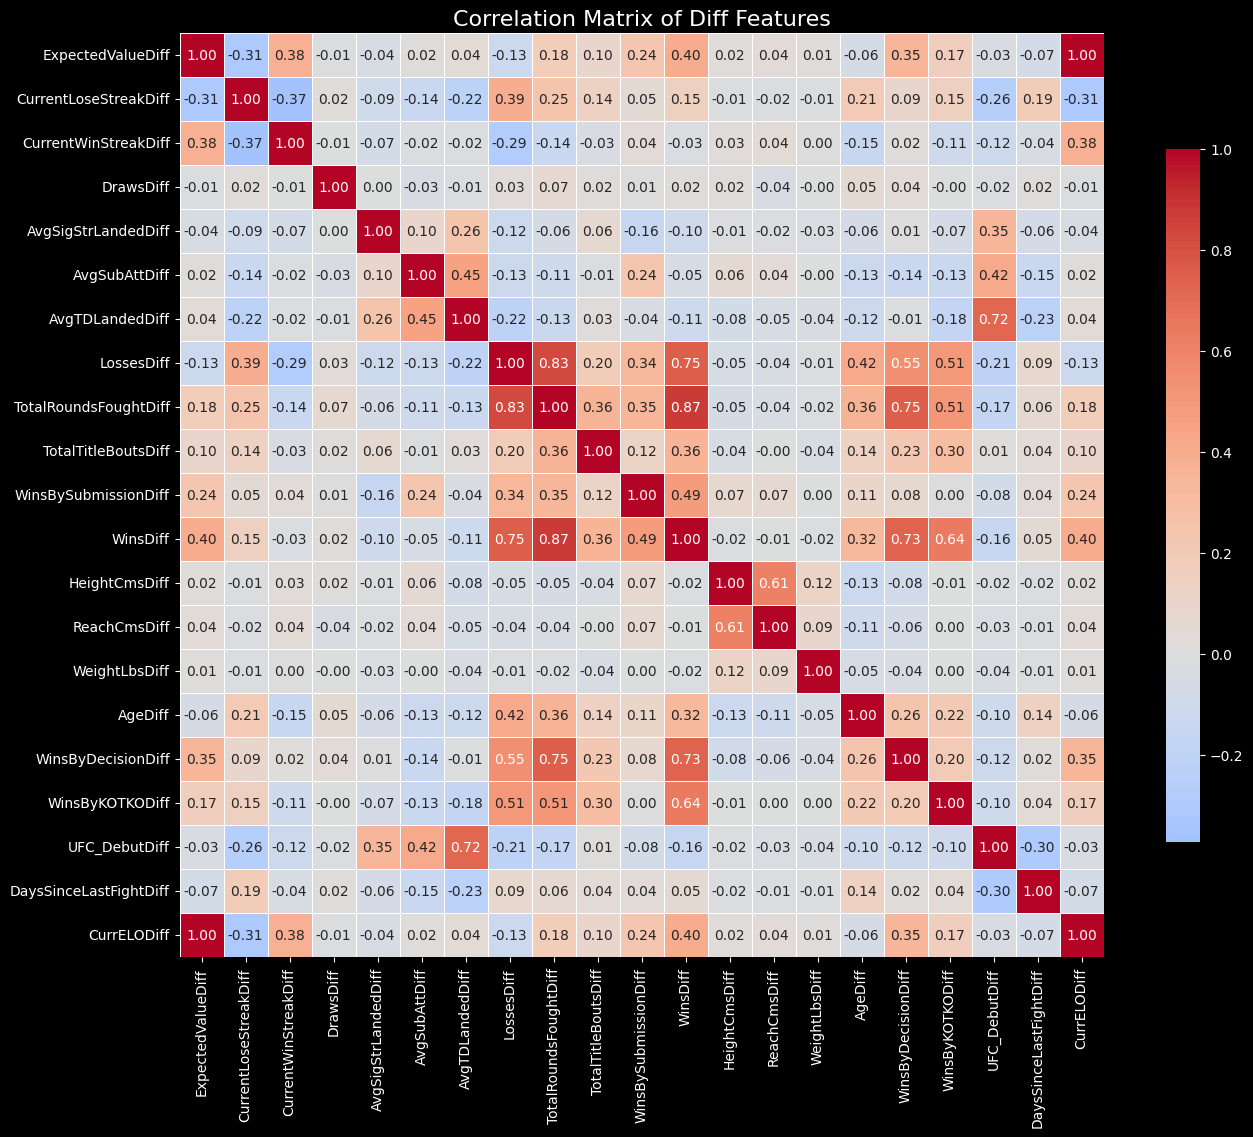

In [27]:
# Compute correlation matrix
corr = numeric_df.corr()

plt.style.use('dark_background')  
plt.figure(figsize=(16, 12))

sns.heatmap(
    corr, 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    center=0, 
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.75}
)

plt.title('Correlation Matrix of Diff Features', fontsize=16)
plt.show()

In [28]:
# Export preprocessed dataset
df.to_csv("../datasets/ufc-clean.csv", index=False)

## Future Improvements

Here are a list of additional features we could consider:
- Convert `NumberOfRounds` into running average rounds lasted per fight
- Convert `TotalFightTimeSecs` into running average fight time 
- Introduce training camp location vs event location (and elevation differences)